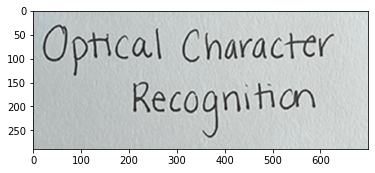

In [ ]:
#Making the necessary imports
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import imutils
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
#The inputImg represents the image that will be taken by the blind person, and 
#then convert it grayscale.
inputImg = cv2.imread('/content/drive/MyDrive/example3.png')
grayImg = cv2.cvtColor(inputImg, cv2.COLOR_BGR2GRAY)
plt.imshow(inputImg, cmap='gray')


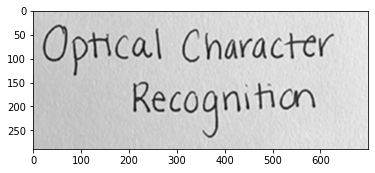

In [ ]:
#We use a filter to blur out the noise from the image.
gaussianFilter = cv2.GaussianBlur(grayImg, (5,5), 0)
plt.imshow(gaussianFilter, cmap="gray")

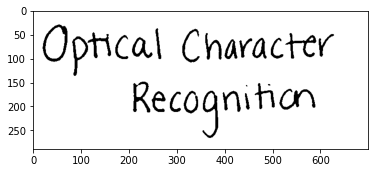

In [ ]:
#binarize and invert the image. 
_, binarizedImg = cv2.threshold(gaussianFilter, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(binarizedImg, cmap="gray")

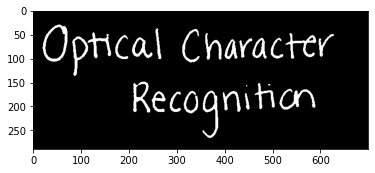

In [ ]:
binarizedImg[binarizedImg == 0] = 1
binarizedImg[binarizedImg == 255] = 0
plt.imshow(binarizedImg, cmap="gray")


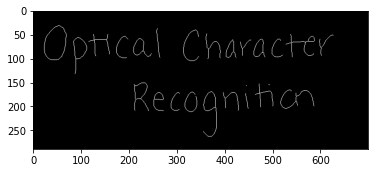

In [ ]:
#Erosion using skeletonize
skeletonImg = skeletonize(binarizedImg)
plt.imshow(skeletonImg, cmap="gray")

In [ ]:
#Horizontal and vertical projections
horizontal_projection = np.sum(skeletonImg, axis=1)
print(horizontal_projection)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  4  4  4  3  4  2  3  3  3  6  7  6  5  6  5  5
  5  6  9 10 13 11 16 16 14 18 16 20 27 48 28 29 27 50 46 27 29 28 28 26
 25 25 25 25 25 25 24 24 23 22 22 22 22 25 23 25 27 25 27 27 28 33 31 24
 33 27 18 16 10 12  9 18  6 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  9  3  4  5  7  6  8  3  3  3  3  3  3  3  4  8 14
 12 17 20 32 27 24 22 21 18 19 20 18 18 18 19 17 25 28 24 16 16 16 18 17
 17 17 17 17 17 17 18 16 15 14 18 18 16 10 13 15 30 12  6  6  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  8  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


In [ ]:
height, width = skeletonImg.shape
print("Height: ", height)
print("Width: ", width)

Height:  289
Width:  700


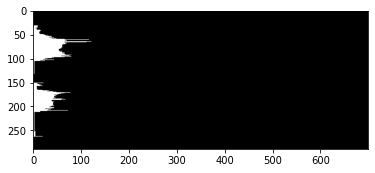

In [ ]:
#create blank canvas and fill it with the projections
blankImg = np.zeros((height, width, 3), np.uint8)
for row in range(height):
  cv2.line(blankImg, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)

plt.imshow(blankImg, cmap="gray")


In [ ]:
#get the lines in the document using the upper and lower cut off points 
upper_breakpoints = []
lower_breakpoints = []
for row in range(height-1):
  if((int(horizontal_projection[row]*width/height) == 0) and (int(horizontal_projection[row+1]*width/height)) != 0):
    upper_breakpoints.append(row)
  if((int(horizontal_projection[row]*width/height) != 0) and (int(horizontal_projection[row+1]*width/height)) == 0):
    lower_breakpoints.append(row)

print(upper_breakpoints)
print(lower_breakpoints)

[31, 150]
[132, 263]


In [ ]:
#store the cropped images. for later segmentation into characters and words. 
images_cropped_1 = []

for num in range(len(upper_breakpoints)):
  img = skeletonImg[upper_breakpoints[num]:upper_breakpoints[num] +(lower_breakpoints[num] - upper_breakpoints[num]), 0:0+width]
  images_cropped_1.append(img)



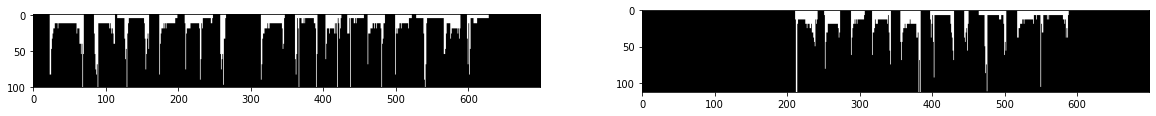

In [ ]:
#Find the characters
left_breakpoints = [[] for i in range(len(images_cropped_1))]
right_breakpoints = [[] for i in range(len(images_cropped_1))]
blankImgs = []
for i in range(len(images_cropped_1)):
  vertical_projection = np.sum(images_cropped_1[i], axis=0)
  height_2, width_2 = images_cropped_1[i].shape
  blankImg2 = np.zeros((height_2, width_2, 3), np.uint8)
  for column in range(width_2-1):
    if ((int(vertical_projection[column]*width_2/height_2) == 0) and (int(vertical_projection[column+1]*width_2/height_2) != 0)):
      left_breakpoints[i].append(column)
    if ((int(vertical_projection[column]*width_2/height_2) != 0) and (int(vertical_projection[column+1]*width_2/height_2) == 0)):
      right_breakpoints[i].append(column)
    cv2.line(blankImg2, (column, 0), (column, int(vertical_projection[column]*width_2/height_2)), (255,255,255), 1)
  blankImgs.append(blankImg2)

figure = plt.figure(figsize=(20, 20))
for i in range(len(blankImgs)):
  figure.add_subplot(2, 2, i+1)
  plt.imshow(blankImgs[i])


In [ ]:
#Find the words 
left_breakpoints_2 = [[] for i in range(len(images_cropped_1))]
right_breakpoints_2 = [[] for i in range(len(images_cropped_1))]
blankWordImgs = []
for i in range(len(images_cropped_1)):
  vertical_projection_1 = np.sum(images_cropped_1[i], axis=0)
  height_3, width_3 = images_cropped_1[i].shape
  blankImg3 = np.zeros((height_3, width_3, 3), np.uint8)
  cv2.line(blankImg3, (column, 0), (column, int(vertical_projection[column]*width_2/height_2)), (255,255,255), 1)

  for column in range(width_3-1):
    if ((int(vertical_projection_1[column]*width_3/height_3) == 0) and (int(vertical_projection_1[column+1]*width_3/height_3) != 0)):
      left_breakpoints_2[i].append(column)

  for column in range(width_3-20):
    if ((int(vertical_projection_1[column]*width_3/height_3) != 0) and (int(vertical_projection_1[column+1]*width_3/height_3) == 0)):
      total = 0
      for clmn in range(20):
        total += int(vertical_projection_1[column + clmn]*width_3/height_3) 
      if (total == 0): 
        right_breakpoints_2[i].append(column)
  
    blankWordImgs.append(blankImg3)


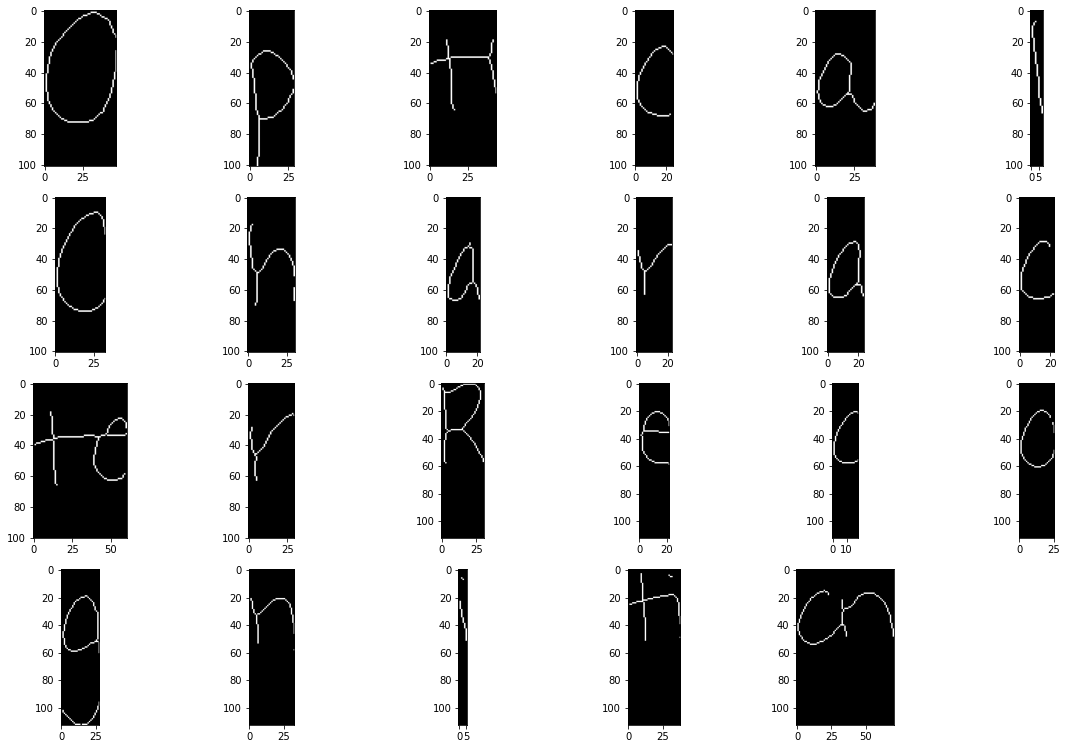

In [ ]:
charImgs = []
for i in range(len(left_breakpoints)):
  for num, num2 in zip(left_breakpoints[i], right_breakpoints[i]):
    img = images_cropped_1[i]
    img = img[0:0+height_2, num: num + num2 - num]
    charImgs.append(img)
    #print(charImgs)

figure = plt.figure(figsize=(20, 20))
for i in range(len(charImgs)):
  figure.add_subplot(6,6,i+1)
  plt.imshow(charImgs[i], cmap='gray')
#We do some processing on the characters that we acquired before to make sure
#they are ready to fill in the model for prediction. 
processedCharImgs = []
for i in range(len(charImgs)):
  (tH, tW) = charImgs[i].shape
  #plt.imshow(charImgs[i])
  charImgs[i] = charImgs[i].astype("uint8") * 255.0
  #print(tH)
  #print(tW)
  if tW > tH:
    charImgs[i] = imutils.resize(charImgs[i], width=32)
  elif tH > tW: 
    charImgs[i] = imutils.resize(charImgs[i], height=32)
  
  (tH, tW) = charImgs[i].shape
  dX = int(max(0, 32-tW) / 2.0)
  dY = int(max(0, 32-tH) / 2.0)

  paddedImg = cv2.copyMakeBorder(charImgs[i], top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
  paddedImg = cv2.resize(paddedImg, (32, 32))

  paddedImg = paddedImg.astype("uint8") * 255.0
  paddedImg = np.expand_dims(paddedImg, axis=-1)
  

  processedCharImgs.append(paddedImg)
   #paddedImgs contains the images that will be sent to the model for prediction
